# Рекомендательная система для данных "Amazon All Beauty (Small)" 

## EDA

In [1]:
import random

import numpy as np
import pandas as pd
import seaborn as sns

my_seed = 42
random.seed(my_seed)
np.random.seed(my_seed)

In [2]:
df = pd.read_csv('All_Beauty.csv', names=['item', 'user', 'rating', 'timestamp'])

In [3]:
df

,item,user,rating,timestamp
0,0143026860,A1V6B6TNIC10QE,1.0,1424304000
1,0143026860,A2F5GHSXFQ0W6J,4.0,1418860800
2,0143026860,A1572GUYS7DGSR,4.0,1407628800
3,0143026860,A1PSGLFK1NSVO,5.0,1362960000
4,0143026860,A6IKXKZMTKGSC,5.0,1324771200
...,...,...,...,...
371340,B01HJEGTYK,A202DCI7TV1022,1.0,1500508800
371341,B01HJEGTYK,A3FSOR5IJOFIBE,5.0,1489622400
371342,B01HJEGTYK,A1B5DK6CTP2P24,5.0,1488326400
371343,B01HJEGTYK,A23OUYS5IRMJS9,2.0,1487635200


Всего в наборе данных содержится 371345 записей. Давайте рассмотрим более детально, как он устроен.

In [4]:
df.describe()

,rating,timestamp
count,371345.000000,3.713450e+05
mean,4.112093,1.440742e+09
std,1.362099,6.962743e+07
min,1.000000,9.474624e+08
25%,4.000000,1.416096e+09
50%,5.000000,1.456963e+09
75%,5.000000,1.485562e+09
max,5.000000,1.538438e+09


In [5]:
df['user'].nunique()

324038

In [6]:
df['item'].nunique()

32586

In [7]:
df['rating'].nunique()

5

Всего уникальных пользователей: 324038     
Всего уникальных товаров: 32586    
Оценки ранжируются от 1 до 5.    

Количество уникальных пользователей чуть меньше, чем количество записей. Однако, данная информация для товаров является неверной.
Таким образом, предположительно, будет предпочтительнее строить рекомендательную систему, основываясь на "похожести" товаров по пользователям.

<AxesSubplot:xlabel='rating', ylabel='Count'>

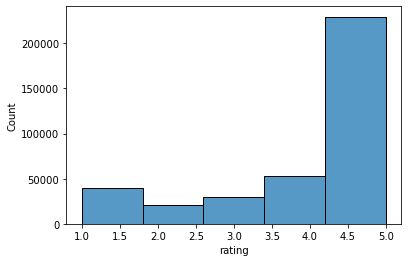

In [8]:
sns.histplot(df, x='rating', bins=5)

Большинству пользователей понравился купленный товар. :) Преобладающее количество оценок лежит в диапазоне от 4 до 5.

## Построение рекомендательной системы при помощи Surprise

### Создание тестового набора данных с учетом timestamp

In [9]:
from surprise import Dataset
from surprise import Reader

In [10]:
prop = 0.9
test_len = int(len(df) * (1 - prop))
train_len = len(df) - test_len

In [11]:
reader = Reader(rating_scale=(1, 5))

train_df = df.sort_values(by='timestamp').reset_index().drop(['timestamp', 'index'], axis=1) \
                                    .reindex(['user', 'item', 'rating'],axis=1).iloc[:train_len]
test_df = df.sort_values(by='timestamp').reset_index().drop(['timestamp', 'index'], axis=1) \
                                    .reindex(['user', 'item', 'rating'],axis=1).iloc[train_len:]

data_train = Dataset.load_from_df(train_df, reader)
data_test = Dataset.load_from_df(test_df, reader)

In [12]:
trainset = data_train.build_full_trainset()

In [13]:
testset = data_test.build_full_trainset().build_testset()

### Построение рекомендательной системы - explicit

In [14]:
from surprise import SVD
from surprise.accuracy import rmse

KNN, BaselineOnly не влезли в память на таких данных :) Применим SVD

In [15]:
algo = SVD(n_factors=32,n_epochs=20, verbose=True)

In [16]:
algo.fit(trainset)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19


In [17]:
predictions = algo.test(testset)

In [18]:
predictions

[Prediction(uid='A1CQO3YVFUV0E9', iid='B019DD2PRU', r_ui=1.0, est=3.7320383273164586, details={'was_impossible': False}),
 Prediction(uid='A194BW4PYD61TB', iid='B01DBOQJJC', r_ui=4.0, est=4.28555668917211, details={'was_impossible': False}),
 Prediction(uid='A12011XZEKAJP8', iid='B00592MMPA', r_ui=5.0, est=3.9823881218157897, details={'was_impossible': False}),
 Prediction(uid='A30APMH1BEHJNI', iid='B0010ZBORW', r_ui=4.0, est=4.013090695556425, details={'was_impossible': False}),
 Prediction(uid='A30APMH1BEHJNI', iid='B0010ZBORW', r_ui=4.0, est=4.013090695556425, details={'was_impossible': False}),
 Prediction(uid='A93YMZM7YKG1G', iid='B0010ZBORW', r_ui=4.0, est=3.8117464433336465, details={'was_impossible': False}),
 Prediction(uid='A93YMZM7YKG1G', iid='B0010ZBORW', r_ui=4.0, est=3.8117464433336465, details={'was_impossible': False}),
 Prediction(uid='A2TS3U2UUW7960', iid='B00481CYIS', r_ui=5.0, est=4.699137985297942, details={'was_impossible': False}),
 Prediction(uid='A1VUTY46IWNYLT

In [19]:
rmse(predictions)

RMSE: 1.4289


1.4289297034665602

Таким образом, наша система отклоняется от "правильного" предсказания в среднем на 1.43 пункта, что является достаточно большим числом, т.к. наши оценки принимают всего 5 значений. Предположительно, построение implicit-модели с использованием большего количества признаков, либо использование более сложных алгоритмов (нейросетевых) поднимет качество предсказания. Вдобавок, набор данных сам по себе не является сбалансированным: много уникальных пользователей, слишком много положительных оценок. Вероятно, это является причиной того, что для многих товаров, алгоритм имеет тенденцию "завышать" оценки относительно реальных.